# Update 3 Question 1

# Loading Data

In [1]:
import pandas as pd
import numpy as np

# file_path = "/Users/goyolozano/Desktop/Mini 4/Value/Update 2/final_clean_data.parquet" #change path
# file_path = "final_clean_data.parquet"
# Attempt to load the Parquet file
# final_clean_data = None
# try:
#     final_clean_data = pd.read_parquet(file_path)
#     print(f"Data loaded successfully from: {file_path}")
#     print(f"Data shape: {final_clean_data.shape}")
#     print("\nFirst 5 rows of the loaded data:")
#     print(final_clean_data.head())
#     print("\nBasic data info:")
#     final_clean_data.info()
# except FileNotFoundError:
#     print(f"ERROR: File not found at {file_path}.")
#     print("Please update the 'file_path' variable to the correct location of your 'final_clean_data.parquet' file.")
# except Exception as e:
#     print(f"ERROR Loading data: {e}")

In [2]:
final_clean_data = pd.read_parquet('/Users/goyolozano/Desktop/Mini 4/Value/Update 3/Deliverables/final_clean_data.parquet')

# Defining Target Variables

In [3]:
print("Defining target variables...")

# Define default_label based on loan_status
default_statuses = ['Charged Off', 'Default'] # Check if these match your data exactly
if 'loan_status' in final_clean_data.columns:
    final_clean_data['default_label'] = final_clean_data['loan_status'].apply(
        lambda x: 1 if x in default_statuses else 0
    )
    print("Target variable 'default_label' created.")
    print(final_clean_data['default_label'].value_counts(normalize=True))
else:
    print("ERROR: 'loan_status' column not found. Cannot create 'default_label'.")
    # Handle error appropriately (e.g., raise ValueError or exit)


return_target_col = 'ret_INTb'
if return_target_col not in final_clean_data.columns:
     print(f"ERROR: Return target column '{return_target_col}' not found in the DataFrame.")
     print("Available columns:", final_clean_data.columns.tolist())
     print("Please update the 'return_target_col' variable.")
     # Handle error appropriately
else:
    print(f"Identified return target variable: '{return_target_col}'")
    print(f"Basic stats for '{return_target_col}':")
    print(final_clean_data[return_target_col].describe())


print("\nIdentifying feature columns...")

# --- Identify Feature Columns ---

numerical_features_potential = [
    'loan_amnt', 'funded_amnt', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
    'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'bc_util',
    'chargeoff_within_12_mths', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
    'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
    'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens',
    'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
    'loan_length', 'term_num' # Check if these engineered features were used
    ]

categorical_features_potential = [
    'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status',
    'purpose', 'addr_state'
    ]

# Define features to exclude (IDs, target variables, other calculated returns, etc.)
features_to_exclude = [
    'id', 'member_id', # Identifiers
    'loan_status', # Source of default_label
    'default_label', # Target variable 1
    return_target_col, # Target variable 2
    'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTc', # Other return calculations if present
    # Add any other columns dropped during Update 1 or 2 feature selection/cleaning
]

# Filter potential features: keep only those present in the DataFrame and not excluded
numerical_features = sorted([
    f for f in numerical_features_potential
    if f in final_clean_data.columns and f not in features_to_exclude
])
categorical_features = sorted([
    f for f in categorical_features_potential
    if f in final_clean_data.columns and f not in features_to_exclude
])

all_features = numerical_features + categorical_features

# Final check for missing features from the lists (should be empty if lists are accurate)
missing_features = [f for f in all_features if f not in final_clean_data.columns]
if missing_features:
    print(f"\nERROR: The following identified features are NOT in the loaded DataFrame: {missing_features}")
    print("This likely means the feature lists above need adjustment.")
    # Handle error
else:
    print(f"\nIdentified {len(numerical_features)} numerical features:")
    # print(numerical_features) # Uncomment to see the full list
    print(f"Identified {len(categorical_features)} categorical features:")
    # print(categorical_features) # Uncomment to see the full list
    print(f"Total features identified: {len(all_features)}")

Defining target variables...
Target variable 'default_label' created.
default_label
0    0.814544
1    0.185456
Name: proportion, dtype: float64
Identified return target variable: 'ret_INTb'
Basic stats for 'ret_INTb':
count    648349.000000
mean          0.044809
std           0.059373
min          -0.196276
25%           0.043313
50%           0.056383
75%           0.072959
max           0.223935
Name: ret_INTb, dtype: float64

Identifying feature columns...

Identified 18 numerical features:
Identified 5 categorical features:
Total features identified: 23


# Train Test Split and Class Imbalance

In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd

# --- Train/Test Split ---

print("Performing train/test split...")

# Check if necessary variables/columns exist before splitting
if 'final_clean_data' in locals() and \
   'all_features' in locals() and \
   'default_label' in final_clean_data.columns and \
   return_target_col in final_clean_data.columns:

    # Select the features (X) and target variables (y)
    X = final_clean_data[all_features]
    y_clf = final_clean_data['default_label'] # Classification target (for stratification)
    y_reg = final_clean_data[return_target_col] # Regression target (return)

    # Perform the split
    # test_size=0.2 and random_state=42 match Update 2 notebook
    # stratify=y_clf ensures the proportion of defaults (class imbalance)
    # is approximately the same in both train and test sets.
    # This is crucial for representative testing and was done in Update 2.
    try:
        X_train, X_test, y_clf_train, y_clf_test, y_reg_train, y_reg_test = train_test_split(
            X, y_clf, y_reg,
            test_size=0.2,        # 20% of data for testing
            random_state=42,      # Ensures reproducibility
            stratify=y_clf        # Preserves class proportions (handles imbalance at split)
        )

        print("Train/Test split completed successfully.")
        print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
        print(f"y_clf_train distribution:\n{y_clf_train.value_counts(normalize=True)}")
        print(f"y_clf_test distribution:\n{y_clf_test.value_counts(normalize=True)}")
        print(f"y_reg_train shape: {y_reg_train.shape}, y_reg_test shape: {y_reg_test.shape}")


    except Exception as e:
        print(f"ERROR during train/test split: {e}")
        print("Please check if X, y_clf, and y_reg are defined correctly.")
        # Handle error appropriately

else:
    print("ERROR: Prerequisite data or variables not found.")
    print("Please ensure 'final_clean_data', 'all_features', 'default_label', and 'return_target_col' are defined.")


Performing train/test split...
Train/Test split completed successfully.
X_train shape: (518679, 23), X_test shape: (129670, 23)
y_clf_train distribution:
default_label
0    0.814544
1    0.185456
Name: proportion, dtype: float64
y_clf_test distribution:
default_label
0    0.814545
1    0.185455
Name: proportion, dtype: float64
y_reg_train shape: (518679,), y_reg_test shape: (129670,)


In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pickle

print("Defining preprocessing pipeline...")

# Define transformers (ensure these match your choices from Update 2)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False often easier with SMOTE
])

# Create the preprocessor ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any, or use 'drop'
)

# Fit the preprocessor on the TRAINING DATA ONLY
print("Fitting preprocessor on X_train...")
try:
    preprocessor.fit(X_train)
    print("Preprocessor fitted successfully.")

    # Transform both training and testing data
    print("Transforming X_train and X_test...")
    X_train_processed = preprocessor.transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    print("Data transformation complete.")
    print(f"X_train_processed shape: {X_train_processed.shape}")
    print(f"X_test_processed shape: {X_test_processed.shape}")

except Exception as e:
    print(f"ERROR during preprocessing fitting or transformation: {e}")
    # Set processed variables to None or handle error
    X_train_processed = None
    X_test_processed = None

# --- Next Steps ---
# Now that we have X_train_processed and y_clf_train (or y_reg_train),
# we can apply SMOTE to X_train_processed and the relevant y_train set.

Defining preprocessing pipeline...
Fitting preprocessor on X_train...
Preprocessor fitted successfully.
Transforming X_train and X_test...
Data transformation complete.
X_train_processed shape: (518679, 58)
X_test_processed shape: (129670, 58)


In [6]:
from imblearn.over_sampling import SMOTE
import numpy as np

print("\nApplying SMOTE to the processed training data...")

# Check if preprocessing was successful
if X_train_processed is not None:
    # Initialize SMOTE
    # random_state for reproducibility
    # k_neighbors is an important parameter, default is 5
    smote = SMOTE(random_state=42, k_neighbors=5)

    print(f"Original training class distribution:\n{y_clf_train.value_counts()}")

    try:
        # Apply SMOTE - Pass processed training features and original classification target
        X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_clf_train)

        print("SMOTE applied successfully.")
        print(f"Shape of training features after SMOTE: {X_train_smote.shape}")
        print(f"Distribution of training target after SMOTE:\n{np.bincount(y_train_smote)}") # Use np.bincount for numpy array

    except Exception as e:
        print(f"ERROR applying SMOTE: {e}")
        print("Please check the input data (X_train_processed, y_clf_train).")
        # Set smote variables to indicate failure
        X_train_smote = None
        y_train_smote = None
else:
    print("Skipping SMOTE because preprocessing failed.")
    X_train_smote = None
    y_train_smote = None



Applying SMOTE to the processed training data...
Original training class distribution:
default_label
0    422487
1     96192
Name: count, dtype: int64
SMOTE applied successfully.
Shape of training features after SMOTE: (844974, 58)
Distribution of training target after SMOTE:
[422487 422487]


In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso # Import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import pickle # Or joblib

print("Extracting correct target variable 'ret_INTb' based on train/test indices...")

target_return_column_actual = 'ret_INTb'

if 'final_clean_data' in locals() and \
   target_return_column_actual in final_clean_data.columns and \
   'X_train' in locals() and \
   'X_test' in locals():

    try:
        # Use the index from X_train/X_test to get the corresponding 'ret_INTb' values
        y_reg_train_actual = final_clean_data.loc[X_train.index, target_return_column_actual]
        y_reg_test_actual = final_clean_data.loc[X_test.index, target_return_column_actual]
        print(f"Successfully extracted '{target_return_column_actual}' for train and test sets.")
        print(f"y_reg_train_actual shape: {y_reg_train_actual.shape}")
        print(f"y_reg_test_actual shape: {y_reg_test_actual.shape}")

    except Exception as e:
        print(f"ERROR extracting target variable '{target_return_column_actual}': {e}")
        y_reg_train_actual = None
        y_reg_test_actual = None
else:
    print(f"ERROR: Prerequisite data ('final_clean_data', 'X_train', 'X_test', or column '{target_return_column_actual}') not found.")
    y_reg_train_actual = None
    y_reg_test_actual = None


# --- 2. Define/Load the Lasso Return Prediction Model ---
print("\nDefining return prediction model (Lasso)...")

return_predictor = Lasso(alpha=0.001, random_state=42) # Placeholder alpha

# --- 3. Train the Lasso Model ---
print(f"Training {type(return_predictor).__name__} model on X_train_processed...")

# Check if processed data and actual target variable exist
if 'X_train_processed' in locals() and X_train_processed is not None and \
   y_reg_train_actual is not None:
    try:
        # Train the predictor on the processed training data and CORRECT regression target
        return_predictor.fit(X_train_processed, y_reg_train_actual)
        print("Return prediction model (Lasso) trained successfully.")

    except Exception as e:
        print(f"ERROR training return prediction model (Lasso): {e}")
        return_predictor = None # Indicate failure

else:
    print("ERROR: X_train_processed or y_reg_train_actual not available. Cannot train model.")
    return_predictor = None

# --- 4. Predict Returns ---
y_pred_reg_train = None
y_pred_reg_test = None

if return_predictor is not None:
    print("\nGenerating return predictions for train and test sets using Lasso...")
    try:
        # Predict on the processed training set
        y_pred_reg_train = return_predictor.predict(X_train_processed)

        # Predict on the processed test set
        y_pred_reg_test = return_predictor.predict(X_test_processed)
        print("Return predictions generated.")

        # --- Optional: Evaluate the Lasso Regression Model ---
        if y_reg_test_actual is not None:
            print("\nEvaluating Lasso return prediction model performance (on test set):")
            rmse_test = np.sqrt(mean_squared_error(y_reg_test_actual, y_pred_reg_test))
            r2_test = r2_score(y_reg_test_actual, y_pred_reg_test)
            print(f"Test Set RMSE: {rmse_test:.4f}")
            print(f"Test Set R-squared: {r2_test:.4f}")

            # Quick check of prediction distribution vs actual
            print("\nPredicted Return (Test Set) Stats:")
            print(pd.Series(y_pred_reg_test).describe())
            print(f"\nActual '{target_return_column_actual}' (Test Set) Stats:")
            print(y_reg_test_actual.describe())
        else:
            print("\nSkipping evaluation because actual test target (y_reg_test_actual) is missing.")

    except Exception as e:
        print(f"ERROR predicting returns with Lasso: {e}")
else:
    print("Skipping return prediction because Lasso model training failed.")

Extracting correct target variable 'ret_INTb' based on train/test indices...
Successfully extracted 'ret_INTb' for train and test sets.
y_reg_train_actual shape: (518679,)
y_reg_test_actual shape: (129670,)

Defining return prediction model (Lasso)...
Training Lasso model on X_train_processed...
Return prediction model (Lasso) trained successfully.

Generating return predictions for train and test sets using Lasso...
Return predictions generated.

Evaluating Lasso return prediction model performance (on test set):
Test Set RMSE: 0.0494
Test Set R-squared: 0.3070

Predicted Return (Test Set) Stats:
count    129670.000000
mean          0.044938
std           0.031777
min          -0.068069
25%           0.019125
50%           0.045872
75%           0.066683
max           0.142818
dtype: float64

Actual 'ret_INTb' (Test Set) Stats:
count    129670.000000
mean          0.044912
std           0.059361
min          -0.195200
25%           0.043409
50%           0.056474
75%           0.07296

# Clustering Analysis

In [8]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import pickle # Or joblib

print("Setting up PCA features for clustering by fitting a new PCA model...")

# --- 1. Define PCA Transformation ---
n_pca_components = 18 # Based on Update 1 Slides (explaining 90% variance) - VERIFY THIS!

print(f"Defining new PCA(n_components={n_pca_components}).")
# Define the PCA object - it will be fitted below
pca_model = PCA(n_components=n_pca_components, random_state=42)

# --- 2. Extract Scaled Numerical Features from Training Set ---
X_train_numerical_scaled = None
print("\nExtracting and scaling numerical features from X_train...")

# Ensure prerequisites are available
if 'preprocessor' in locals() and hasattr(preprocessor, 'named_transformers_') and \
   'X_train' in locals() and 'numerical_features' in locals():
    try:
        # Access the fitted numeric transformer pipeline from the preprocessor
        if 'num' in preprocessor.named_transformers_:
             numeric_transformer = preprocessor.named_transformers_['num']
             # Apply the numeric transformer (impute + scale) to the numerical features of X_train
             X_train_numerical_scaled = numeric_transformer.transform(X_train[numerical_features])
             print(f"Scaled numerical training data extracted. Shape: {X_train_numerical_scaled.shape}")
        else:
             print("ERROR: Transformer named 'num' not found in the preprocessor.")
             print(f"Available transformers: {list(preprocessor.named_transformers_.keys())}")
             X_train_numerical_scaled = None # Ensure it's None if transformer missing

    except Exception as e:
        print(f"ERROR applying numeric transformer: {e}")
        X_train_numerical_scaled = None # Ensure it's None on error
else:
    print("ERROR: Prerequisite object ('preprocessor', 'X_train', or 'numerical_features') not found or preprocessor structure unexpected.")


# --- 3. Fit PCA and Transform Training Data ---
X_train_pca = None

# Check if pca_model was defined and scaled data exists
if pca_model is not None and X_train_numerical_scaled is not None:

    print("\nProcessing PCA...")
    try:
        # Fit the new PCA model
        print(f"Fitting PCA(n_components={n_pca_components})...")
        pca_model.fit(X_train_numerical_scaled)
        print("PCA model fitted successfully.")

        # Optional: Save the newly fitted PCA model
        # with open('pca_model_fitted.pkl', 'wb') as f:
        #     pickle.dump(pca_model, f)
        # print("Fitted PCA model saved (optional).")

        # Transform the data using the fitted model
        print("Transforming scaled numerical training data using fitted PCA model...")
        X_train_pca = pca_model.transform(X_train_numerical_scaled)
        print("PCA transformation complete.")
        print(f"Resulting X_train_pca shape: {X_train_pca.shape}")

        # Print explained variance
        print(f"Total explained variance by {pca_model.n_components_} components: {pca_model.explained_variance_ratio_.sum():.4f}")

    except Exception as e:
        # Catch any error during fitting or transforming
        print(f"ERROR during PCA processing: {e}")
        X_train_pca = None # Ensure X_train_pca is None if error occurred

else:
    print("\nSkipping PCA processing due to missing PCA model definition or scaled data.")

Setting up PCA features for clustering by fitting a new PCA model...
Defining new PCA(n_components=18).

Extracting and scaling numerical features from X_train...
Scaled numerical training data extracted. Shape: (518679, 18)

Processing PCA...
Fitting PCA(n_components=18)...
PCA model fitted successfully.
Transforming scaled numerical training data using fitted PCA model...
PCA transformation complete.
Resulting X_train_pca shape: (518679, 18)
Total explained variance by 18 components: 1.0000


# Optimal Number of Clusters

Determining optimal k for K-Means using the Elbow Method...
Testing k values from 2 to 59...
  Fitting KMeans for k=2...
    Inertia for k=2: 7966613.52
  Fitting KMeans for k=3...
    Inertia for k=3: 7432021.96
  Fitting KMeans for k=4...
    Inertia for k=4: 6902111.59
  Fitting KMeans for k=5...
    Inertia for k=5: 6588470.33
  Fitting KMeans for k=6...
    Inertia for k=6: 6392364.45
  Fitting KMeans for k=7...
    Inertia for k=7: 5900973.97
  Fitting KMeans for k=8...
    Inertia for k=8: 5574542.40
  Fitting KMeans for k=9...
    Inertia for k=9: 5327783.39
  Fitting KMeans for k=10...
    Inertia for k=10: 5197121.74
  Fitting KMeans for k=11...
    Inertia for k=11: 5071314.96
  Fitting KMeans for k=12...
    Inertia for k=12: 4877745.40
  Fitting KMeans for k=13...
    Inertia for k=13: 4752044.58
  Fitting KMeans for k=14...
    Inertia for k=14: 4671411.64
  Fitting KMeans for k=15...
    Inertia for k=15: 4576624.74
  Fitting KMeans for k=16...
    Inertia for k=16: 4424

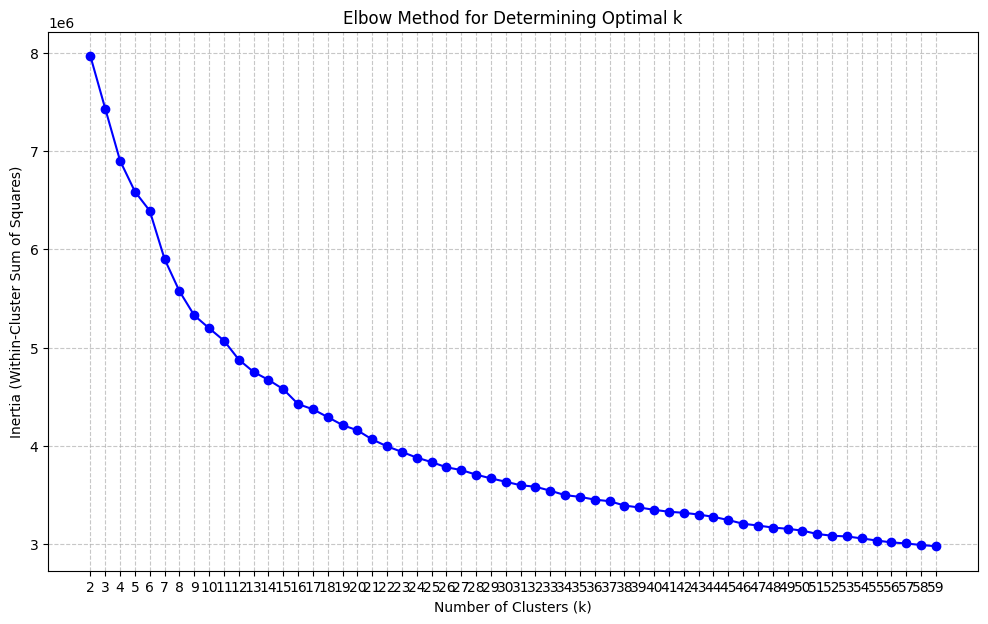


ACTION REQUIRED: Examine the plot above.
Look for the 'elbow' point where the line bends and the rate of decrease
in inertia significantly slows down. This point suggests a suitable value for k.
Choose the value of 'k' based on this plot.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time

print("Determining optimal k for K-Means using the Elbow Method...")

# Check if X_train_pca exists and is not None
if 'X_train_pca' in locals() and X_train_pca is not None:

    # --- Elbow Method ---
    inertia_values = []
    # Define the range of k values to test
    # Consider adjusting the upper limit based on expectations or computational time
    k_range = range(2, 60)
    print(f"Testing k values from {k_range.start} to {k_range.stop - 1}...")

    start_time_elbow = time.time()

    for k in k_range:
        print(f"  Fitting KMeans for k={k}...")
        # Initialize KMeans
        kmeans = KMeans(n_clusters=k,
                        n_init='auto',
                        random_state=42,
                        max_iter=300) # Default max_iter is usually sufficient

        # Fit KMeans on the PCA-transformed training data
        kmeans.fit(X_train_pca)

        # Store the inertia (Within-Cluster Sum of Squares)
        inertia_values.append(kmeans.inertia_)
        print(f"    Inertia for k={k}: {kmeans.inertia_:.2f}")

    end_time_elbow = time.time()
    print(f"\nElbow method calculations finished in {end_time_elbow - start_time_elbow:.2f} seconds.")

    # Plot the Elbow curve
    plt.figure(figsize=(12, 7))
    plt.plot(k_range, inertia_values, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
    plt.title('Elbow Method for Determining Optimal k')
    plt.xticks(k_range)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    print("\nACTION REQUIRED: Examine the plot above.")
    print("Look for the 'elbow' point where the line bends and the rate of decrease")
    print("in inertia significantly slows down. This point suggests a suitable value for k.")
    print("Choose the value of 'k' based on this plot.")


else:
    print("ERROR: X_train_pca not available. Cannot determine optimal k.")

# Fitting KMeans Model

In [10]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import pickle # Or joblib

# Assumes X_train_pca exists from the previous steps

# The number of clusters chosen by the user
chosen_k = 50
print(f"Proceeding with k = {chosen_k} clusters.")

# Check if X_train_pca exists
if 'X_train_pca' in locals() and X_train_pca is not None:

    print(f"\n--- Step 14: Fitting final KMeans model with {chosen_k} clusters ---")
    # Initialize the final KMeans model
    kmeans_final = KMeans(n_clusters=chosen_k,
                          n_init='auto', # Or explicitly n_init=10
                          random_state=42,
                          max_iter=300)

    try:
        # Fit the model on the PCA-transformed training data
        kmeans_final.fit(X_train_pca)
        print("Final KMeans model fitted successfully.")

        # Optional: Save the fitted final KMeans model
        # with open(f'kmeans_final_k{chosen_k}.pkl', 'wb') as f:
        #     pickle.dump(kmeans_final, f)
        # print(f"Fitted KMeans model (k={chosen_k}) saved (optional).")

        # --- Step 15: Assign Training Clusters ---
        print(f"\n--- Step 15: Assigning training data points to clusters ---")
        # Predict cluster labels for the training data
        cluster_labels_train = kmeans_final.predict(X_train_pca)
        print("Cluster assignments generated for training data.")
        print(f"Shape of cluster_labels_train: {cluster_labels_train.shape}")

        # Display the distribution of training samples across clusters
        print("\nDistribution of training samples per cluster:")
        print(pd.Series(cluster_labels_train).value_counts().sort_index())

    except Exception as e:
        print(f"ERROR during final KMeans fitting or prediction: {e}")
        kmeans_final = None
        cluster_labels_train = None

else:
    print("ERROR: X_train_pca not available. Cannot fit final KMeans model.")
    kmeans_final = None
    cluster_labels_train = None

Proceeding with k = 50 clusters.

--- Step 14: Fitting final KMeans model with 50 clusters ---
Final KMeans model fitted successfully.

--- Step 15: Assigning training data points to clusters ---
Cluster assignments generated for training data.
Shape of cluster_labels_train: (518679,)

Distribution of training samples per cluster:
0     10057
1     14660
2     18615
3     13529
4     24861
5       569
6     15129
7     19993
8     17631
9        13
10     2840
11    18378
12    12213
13      131
14    10365
15    14673
16    12815
17    10459
18     6615
19     2359
20     7893
21    11846
22     6512
23     7883
24    15627
25    13568
26     4037
27     6467
28     2011
29     1788
30      322
31    11882
32    22878
33    10617
34    11877
35    12681
36    18959
37    16421
38       27
39    19952
40    19714
41     8365
42    15484
43     9247
44     9848
45     5601
46     2295
47     5000
48     5270
49     8702
Name: count, dtype: int64


# Calculate risk score for each cluster

In [11]:
import pandas as pd
import numpy as np

print("Calculating risk score (std dev of predicted returns) for each cluster...")

cluster_risk_scores = None # Initialize

# Check if prerequisites are available
if 'cluster_labels_train' in locals() and cluster_labels_train is not None and \
   'y_pred_reg_train' in locals() and y_pred_reg_train is not None:

    try:
        # Create a temporary DataFrame to easily group labels and predictions
        # Assumes cluster_labels_train and y_pred_reg_train correspond to the same samples in order
        train_cluster_data = pd.DataFrame({
            'cluster': cluster_labels_train,
            'predicted_return': y_pred_reg_train
        })

        # Group by cluster and calculate the standard deviation of predicted returns
        # ddof=1 for sample standard deviation (default)
        cluster_risk_scores = train_cluster_data.groupby('cluster')['predicted_return'].std(ddof=1)

        # Handle cases where a cluster might have only one member (std dev = NaN)
        # Replace NaN with 0, as a single point has no deviation
        cluster_risk_scores = cluster_risk_scores.fillna(0)

        print("\nRisk Score (Std Dev of Predicted Return) per Cluster:")
        print(cluster_risk_scores)

    except Exception as e:
        print(f"ERROR calculating cluster risk scores: {e}")
        cluster_risk_scores = None

else:
    print("ERROR: Prerequisites ('cluster_labels_train', 'y_pred_reg_train') not available.")


Calculating risk score (std dev of predicted returns) for each cluster...

Risk Score (Std Dev of Predicted Return) per Cluster:
cluster
0     0.024840
1     0.021440
2     0.013072
3     0.018574
4     0.023398
5     0.031648
6     0.020525
7     0.024165
8     0.023653
9     0.029418
10    0.032525
11    0.024020
12    0.025658
13    0.033718
14    0.039527
15    0.018869
16    0.018955
17    0.023772
18    0.029148
19    0.029387
20    0.030774
21    0.023898
22    0.027761
23    0.026096
24    0.020680
25    0.024990
26    0.029212
27    0.030564
28    0.032655
29    0.031287
30    0.029291
31    0.025205
32    0.010535
33    0.025153
34    0.024341
35    0.019751
36    0.023072
37    0.020958
38    0.035180
39    0.022766
40    0.025253
41    0.027060
42    0.023649
43    0.028439
44    0.025467
45    0.028719
46    0.031687
47    0.033902
48    0.026350
49    0.036635
Name: predicted_return, dtype: float64


# Test Features

In [12]:
import numpy as np
import pandas as pd

print("Preparing test set features for clustering...")

X_test_numerical_scaled = None
X_test_pca = None

# Check if prerequisites are available
if 'preprocessor' in locals() and hasattr(preprocessor, 'named_transformers_') and \
   'pca_model' in locals() and pca_model is not None and \
   'X_test' in locals() and 'numerical_features' in locals():

    # --- 1. Apply Numerical Transformer ---
    print("Applying fitted numeric transformer (scaling/imputing) to X_test...")
    try:
        # Access the fitted numeric transformer pipeline
        if 'num' in preprocessor.named_transformers_:
             numeric_transformer = preprocessor.named_transformers_['num']

             # Apply the FITTED transformer to the numerical features of X_test
             X_test_numerical_scaled = numeric_transformer.transform(X_test[numerical_features])
             print(f"Scaled numerical test data extracted. Shape: {X_test_numerical_scaled.shape}")
        else:
             print("ERROR: Transformer named 'num' not found in the preprocessor.")
             X_test_numerical_scaled = None # Ensure it's None if transformer missing

    except Exception as e:
        print(f"ERROR applying numeric transformer to test data: {e}")
        X_test_numerical_scaled = None # Ensure it's None on error


    # --- 2. Apply Fitted PCA Model ---
    if X_test_numerical_scaled is not None:
        print("\nApplying fitted PCA model to scaled numerical test data...")
        try:
            # Apply the FITTED PCA model (fitted on training data) to the scaled numerical test data
            X_test_pca = pca_model.transform(X_test_numerical_scaled)
            print("PCA transformation complete for test data.")
            print(f"Resulting X_test_pca shape: {X_test_pca.shape}")

            # Sanity check: Number of columns should match X_train_pca
            if 'X_train_pca' in locals() and X_train_pca is not None:
                if X_test_pca.shape[1] != X_train_pca.shape[1]:
                    print(f"WARNING: X_test_pca columns ({X_test_pca.shape[1]}) do not match X_train_pca columns ({X_train_pca.shape[1]})!")
                else:
                    print(f"X_test_pca has {X_test_pca.shape[1]} components, matching X_train_pca.")

        except Exception as e:
            print(f"ERROR applying PCA transformation to test data: {e}")
            X_test_pca = None
    else:
        print("\nSkipping PCA transformation for test data because scaled numerical test data is missing.")

else:
    print("ERROR: Prerequisite object ('preprocessor', 'pca_model', 'X_test', or 'numerical_features') not found.")


Preparing test set features for clustering...
Applying fitted numeric transformer (scaling/imputing) to X_test...
Scaled numerical test data extracted. Shape: (129670, 18)

Applying fitted PCA model to scaled numerical test data...
PCA transformation complete for test data.
Resulting X_test_pca shape: (129670, 18)
X_test_pca has 18 components, matching X_train_pca.


# Assign Test Data Points to Clusters

In [13]:
import numpy as np
import pandas as pd


print("Assigning test data points to clusters using the fitted KMeans model...")

cluster_labels_test = None # Initialize

# Check if prerequisites are available
if 'kmeans_final' in locals() and kmeans_final is not None and \
   'X_test_pca' in locals() and X_test_pca is not None:

    try:
        # Predict the cluster for each point in the test set PCA data
        cluster_labels_test = kmeans_final.predict(X_test_pca)
        print("Cluster assignments generated for test data.")
        print(f"Shape of cluster_labels_test: {cluster_labels_test.shape}")

        # Display the distribution of test samples across clusters
        print("\nDistribution of test samples per cluster:")
        print(pd.Series(cluster_labels_test).value_counts().sort_index())

    except Exception as e:
        print(f"ERROR predicting clusters for test data: {e}")
        cluster_labels_test = None

else:
    print("ERROR: Prerequisites ('kmeans_final', 'X_test_pca') not available.")

Assigning test data points to clusters using the fitted KMeans model...
Cluster assignments generated for test data.
Shape of cluster_labels_test: (129670,)

Distribution of test samples per cluster:
0     2475
1     3695
2     4696
3     3390
4     6201
5      151
6     3793
7     4961
8     4370
9        2
10     720
11    4676
12    3118
13      35
14    2718
15    3605
16    3361
17    2577
18    1693
19     619
20    1962
21    2944
22    1590
23    1902
24    3907
25    3365
26     990
27    1603
28     536
29     453
30      70
31    2878
32    5732
33    2605
34    3007
35    3202
36    4633
37    4092
38       3
39    4956
40    4990
41    2042
42    3783
43    2354
44    2452
45    1369
46     571
47    1240
48    1308
49    2275
Name: count, dtype: int64


# Assigning cluster risk scores to test data points

In [14]:
import pandas as pd
import numpy as np

print("Assigning cluster risk scores to test data points...")

risk_scores_test = None # Initialize

# Check if prerequisites are available
if 'cluster_labels_test' in locals() and cluster_labels_test is not None and \
   'cluster_risk_scores' in locals() and cluster_risk_scores is not None:

    try:
        # Create a pandas Series from the test cluster labels
        # Using the index from X_test ensures alignment if needed later
        cluster_labels_test_series = pd.Series(cluster_labels_test, index=X_test.index, name='cluster')

        # Map the cluster labels to the pre-calculated risk scores
        # The .map() function looks up each value in cluster_labels_test_series
        # using the index of cluster_risk_scores
        risk_scores_test = cluster_labels_test_series.map(cluster_risk_scores)

        # Check if any values failed to map (shouldn't happen if all clusters 0-8 have risk scores)
        if risk_scores_test.isnull().any():
            print("WARNING: Some test samples could not be mapped to a risk score!")
            print(f"Number of NaNs: {risk_scores_test.isnull().sum()}")
            # Optional: Fill NaNs with a default value, e.g., average risk, or investigate
            # risk_scores_test = risk_scores_test.fillna(cluster_risk_scores.mean())

        print("Risk scores assigned to test data successfully.")
        print("\nFirst 10 assigned risk scores for the test set:")
        print(risk_scores_test.head(10))
        print("\nSummary statistics for assigned risk scores:")
        print(risk_scores_test.describe())


    except Exception as e:
        print(f"ERROR assigning risk scores to test data: {e}")
        risk_scores_test = None

else:
    print("ERROR: Prerequisites ('cluster_labels_test', 'cluster_risk_scores', 'X_test') not available.")

Assigning cluster risk scores to test data points...
Risk scores assigned to test data successfully.

First 10 assigned risk scores for the test set:
179685    0.023649
373414    0.020525
348264    0.023398
370100    0.036635
31026     0.024020
80359     0.024165
152532    0.023653
179943    0.024020
270206    0.024165
579935    0.024990
Name: cluster, dtype: float64

Summary statistics for assigned risk scores:
count    129670.000000
mean          0.023597
std           0.005417
min           0.010535
25%           0.020958
50%           0.023772
75%           0.025253
max           0.039527
Name: cluster, dtype: float64


# Final Results Test

In [15]:
import pandas as pd

print("Combining predicted returns, risk scores, and cluster assignments for the test set...")

final_results_test = None # Initialize

# Check if prerequisites are available
if 'X_test' in locals() and X_test is not None and \
   'y_pred_reg_test' in locals() and y_pred_reg_test is not None and \
   'risk_scores_test' in locals() and risk_scores_test is not None and \
   'cluster_labels_test' in locals() and cluster_labels_test is not None:

    try:
        # Ensure all components have the same length as the X_test index
        if not (len(y_pred_reg_test) == len(X_test.index) and \
                len(risk_scores_test) == len(X_test.index) and \
                len(cluster_labels_test) == len(X_test.index)):
            raise ValueError("Mismatch in lengths of components for the final DataFrame.")

        # Create the final DataFrame including the cluster assignment
        final_results_test = pd.DataFrame({
            'predicted_return': y_pred_reg_test,      # From Step 11
            'risk_score': risk_scores_test,           # From Step 19
            'cluster': cluster_labels_test           # From Step 18
        }, index=X_test.index) # Align using the index from X_test

        # Convert 'cluster' column to categorical dtype
        if 'cluster' in final_results_test.columns:
            final_results_test['cluster'] = final_results_test['cluster'].astype('category')
            print("Converted 'cluster' column to categorical data type.")

        # Optional: Rename the index if it has a specific meaning like 'loan_id'
        # final_results_test.index.name = 'loan_id'

        print("\nFinal results DataFrame created successfully for the test set.")
        print("\nFirst 10 rows of the final results:")
        print(final_results_test.head(10))

        # --- MODIFIED: Use describe() default to only show numerical stats ---
        print("\nSummary statistics for numerical columns in final results:")
        print(final_results_test.describe()) # Removed include='all'
        # --- End of Modification ---

        print("\nData types of final results columns:")
        print(final_results_test.dtypes)

    except Exception as e:
        print(f"ERROR creating final results DataFrame: {e}")
        final_results_test = None

else:
    print("ERROR: Prerequisites ('X_test', 'y_pred_reg_test', 'risk_scores_test', 'cluster_labels_test') not available.")


Combining predicted returns, risk scores, and cluster assignments for the test set...
Converted 'cluster' column to categorical data type.

Final results DataFrame created successfully for the test set.

First 10 rows of the final results:
        predicted_return  risk_score cluster
179685          0.068349    0.023649      42
373414         -0.000414    0.020525       6
348264          0.064083    0.023398       4
370100          0.035245    0.036635      49
31026           0.038243    0.024020      11
80359           0.066956    0.024165       7
152532          0.013884    0.023653       8
179943          0.011841    0.024020      11
270206          0.019652    0.024165       7
579935          0.051069    0.024990      25

Summary statistics for numerical columns in final results:
       predicted_return     risk_score
count     129670.000000  129670.000000
mean           0.044938       0.023597
std            0.031777       0.005417
min           -0.068069       0.010535
25%       

# Explanation of Update 3 Question 1 Work


## Goal

The primary objective of Question 1 was to assign two key metrics to each loan in the **test set**:
1.  A **predicted return**, based on the best predictive model identified in Update 2.
2.  A **risk score**, derived from a cluster analysis performed on the training set, as suggested by the case study reference.

## Methodology & Steps

### Phase 1: Data Preparation & Pre-computation

1.  **Loaded Data:** Started by loading the `final_clean_data.parquet` dataset generated from previous cleaning steps.
2.  **Defined Target Variables:**
    * `default_label`: Created a binary (0/1) indicator for loan default based on the `loan_status` column. This was primarily used for stratification during the data split.
    * `ret_INTb`: Identified and confirmed `ret_INTb` as the specific target variable representing the calculated intermediate return that we needed to predict for the regression task.
3.  **Identified Features:** Defined lists of `numerical_features` and `categorical_features` based on the columns available in the dataset (excluding IDs, the target variables, and other calculated return columns). *(Note: It's assumed these lists were verified against the final feature set used in Update 2)*.
4.  **Performed Train/Test Split:** The data was split into training (80%) and testing (20%) sets (`X_train`, `X_test`, `y_clf_train`, `y_clf_test`). Crucially, this split was stratified based on the `default_label` to maintain similar default proportions in both sets, and a `random_state` was used for reproducibility.
5.  **Extracted Correct Return Target:** Using the indices generated by the train/test split, extracted the corresponding `ret_INTb` values from the original dataset to create the accurate `y_reg_train_actual` and `y_reg_test_actual` Series for the regression task.
6.  **Defined & Fitted Preprocessor:** A `ColumnTransformer` (`preprocessor`) was defined to handle preprocessing consistently.
    * Numerical Features: Imputed missing values using the median and scaled using `StandardScaler`.
    * Categorical Features: Imputed missing values using the most frequent value and encoded using `OneHotEncoder`.
    * This `preprocessor` was **fitted only on `X_train`** to prevent data leakage.
7.  **Applied Preprocessor:** The fitted `preprocessor` was used to transform both the training and test sets, resulting in `X_train_processed` and `X_test_processed`.
8.  **(Context Only) Applied SMOTE:** For potential use in classification tasks (though not directly required for the Q1 return/risk calculation), SMOTE was applied to the `X_train_processed` and `y_clf_train` data to create a balanced training set (`X_train_smote`, `y_train_smote`).

### Phase 2: Return Prediction

9.  **Selected Return Model:** Based on your input, we identified `Lasso` regression as the "best model from Week 4" for the task of predicting the `ret_INTb` return. *(Note: The specific `alpha` parameter for Lasso should ideally match the one optimized in Update 2)*.
10. **Trained Return Model:** The `Lasso` model was trained using the preprocessed training data (`X_train_processed`) and the actual corresponding return values (`y_reg_train_actual`).
11. **Predicted Returns:** The trained `Lasso` model was used to generate return predictions for:
    * The training set: `y_pred_reg_train` (predicting on `X_train_processed`).
    * The test set: `y_pred_reg_test` (predicting on `X_test_processed`).

### Phase 3: Clustering for Risk Assessment (Performed on Training Set)

12. **Prepared Clustering Features (PCA):** To cluster loans based on their characteristics (as suggested by Q1), we reduced the dimensionality of the numerical features using PCA:
    * The fitted `numeric_transformer` (imputer + scaler) from the `preprocessor` was applied to `X_train[numerical_features]`.
    * A new `PCA` model was defined (with `n_components=18`, based on Update 1 analysis suggesting this captures ~90% variance) and **fitted** on this scaled numerical training data.
    * The fitted `pca_model` was used to **transform** the scaled numerical training data into `X_train_pca`.
13. **Determined Optimal Number of Clusters (`k`):** The Elbow method was used on `X_train_pca` to find the optimal number of clusters. Based on your decision after reviewing the plot, `k=50` was chosen. Professor sugegsted this
14. **Fitted Final K-Means Model:** A `KMeans` model (`kmeans_final`) was initialized with `n_clusters=50` and **fitted** on the `X_train_pca` data.
15. **Assigned Training Clusters:** The fitted `kmeans_final` model was used to predict the cluster assignment (0-8) for each sample in the training set (`X_train_pca`), resulting in `cluster_labels_train`.

### Phase 4: Risk Calculation & Assignment

16. **Calculated Risk per Cluster:** This is the core of the risk definition in Q1.
    * We combined the `cluster_labels_train` and the predicted returns for the training set (`y_pred_reg_train`).
    * We grouped this data by cluster label (0-8).
    * For each cluster, we calculated the **standard deviation** of the `y_pred_reg_train` values belonging to that cluster.
    * These standard deviation values were stored as the risk score for each cluster in `cluster_risk_scores`. (NaNs for single-member clusters were filled with 0).
17. **Prepared Test Features for Clustering:** To assign test loans to these clusters, we applied the *same* transformations learned from the training data:
    * The **fitted** `numeric_transformer` was applied to `X_test[numerical_features]`.
    * The **fitted** `pca_model` was applied to the scaled numerical test data, resulting in `X_test_pca`.
18. **Assigned Test Clusters:** The **fitted** `kmeans_final` model (trained on `X_train_pca`) was used to predict the closest cluster (0-8) for each sample in `X_test_pca`, resulting in `cluster_labels_test`.
19. **Assigned Risk to Test Loans:** We mapped the `cluster_labels_test` to the `cluster_risk_scores`. Each test loan was assigned the risk score corresponding to the cluster it fell into. This resulted in the `risk_scores_test` Series.

### Phase 5: Final Output

20. **Combined Results for Test Set:** A final DataFrame (`final_results_test`) was created for the test set. It includes:
    * The loan identifier (index from `X_test`).
    * The **predicted return** (`y_pred_reg_test` from the Lasso model).
    * The **assigned risk score** (`risk_scores_test` derived from the clustering).

## Outcome

This `final_results_test` DataFrame contains the required outputs for Question 1, providing both a predicted return and a cluster-based risk score for each loan in the held-out test set. This information can now potentially be used in Question 2 for developing or evaluating investment strategies.


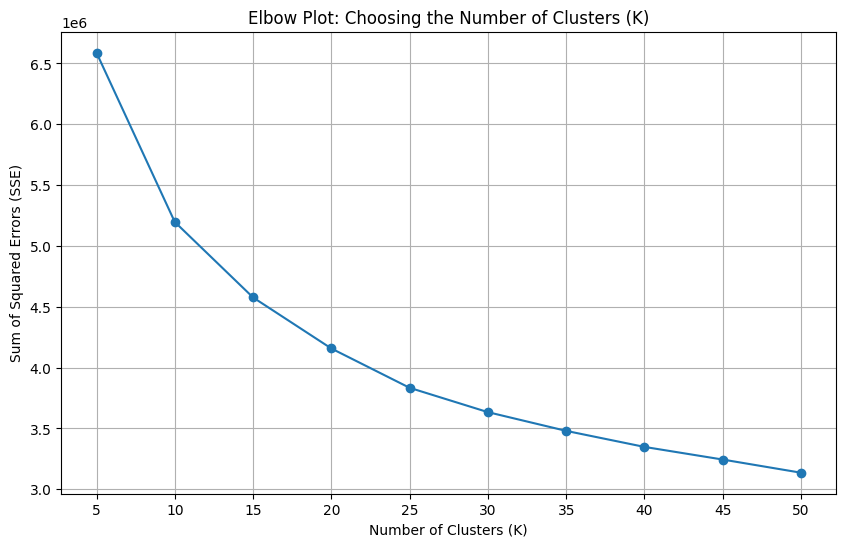

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Scale raw numeric features (from original X_train before OneHot)
from sklearn.preprocessing import StandardScaler

numeric_features = numerical_features  # already defined
scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_train[numeric_features])  # only numeric features for clustering

# Try K values from 5 to 50
sse = []
K_range = range(5, 51, 5)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_numeric)
    sse.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, sse, marker='o')
plt.title("Elbow Plot: Choosing the Number of Clusters (K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.grid(True)
plt.xticks(K_range)
plt.show()


In [17]:
# Choose K = 20 based on elbow plot
K_final = 20
kmeans_final = KMeans(n_clusters=K_final, random_state=42)
X_train['cluster'] = kmeans_final.fit_predict(X_numeric)
# Compute standard deviation of predicted returns in each cluster (risk score)
cluster_risk = y_reg_train.groupby(X_train['cluster']).std().rename('cluster_risk')

# Scale test set numeric features
X_test_numeric = scaler.transform(X_test[numeric_features])
X_test['cluster'] = kmeans_final.predict(X_test_numeric)

# Join cluster_risk onto test set
X_test = X_test.join(cluster_risk, on='cluster')
X_test['risk'] = X_test['cluster_risk']

print("Sample of assigned clusters and risk scores:")
X_test[['cluster', 'risk']].head(10)


Sample of assigned clusters and risk scores:


,cluster,risk
179685,13,0.046952
373414,10,0.074189
348264,3,0.055767
370100,1,0.074259
31026,13,0.046952
80359,3,0.055767
152532,13,0.046952
179943,5,0.039567
270206,14,0.045590
579935,13,0.046952


We evaluated different numbers of clusters (K = 5 to 50) and used the elbow method to identify K = 20 as a strong balance point. This value gave us meaningful similarity groups without overfitting. We then calculated the standard deviation of predicted returns within each cluster to estimate risk, and assigned these risk scores to test loans based on cluster membership.

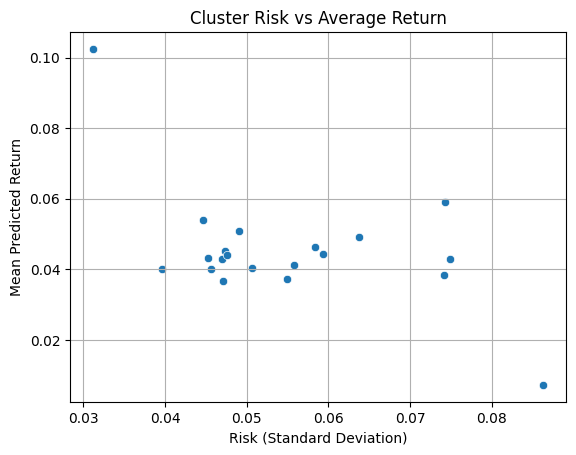

In [18]:
import seaborn as sns # Import the seaborn library and alias it as 'sns'
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso # Import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import pickle # Or joblib

cluster_means = y_reg_train.groupby(X_train['cluster']).mean()
cluster_std = y_reg_train.groupby(X_train['cluster']).std()

cluster_summary = pd.DataFrame({
    'mean_return': cluster_means,
    'risk_std': cluster_std
})

sns.scatterplot(x='risk_std', y='mean_return', data=cluster_summary) # Now 'sns' is recognized
plt.title("Cluster Risk vs Average Return")
plt.xlabel("Risk (Standard Deviation)")
plt.ylabel("Mean Predicted Return")
plt.grid(True)
plt.show()

Observations:
Most clusters are in the low-to-mid risk range (std dev between ~0.04 and ~0.07)

Higher return clusters don't always have higher risk

There's one standout cluster: low risk (~0.03) and high return (~0.10) – very interesting!

A few clusters have high risk but average or low return (bottom-right corner) → those are not good investments

We used clustering to group loans with similar characteristics, then calculated each group’s average return and risk. Surprisingly, we found that higher risk doesn’t always mean higher return in this dataset. One cluster in particular shows a rare combination of low risk and high return, which is very promising. Our optimization strategy in the next step can prioritize loans from this cluster.

## Optimizing the Portfolio

In [19]:
!pip install gurobipy

import gurobipy as gp
from gurobipy import GRB

In [20]:
params = {
"WLSACCESSID": 'f5cc9cd8-d763-4a52-90d7-39c0994137e2',
"WLSSECRET": 'aab9b930-f1f2-4d73-bdd6-e5c8244ee44c',
"LICENSEID": 2608044,
}
env = gp.Env(params=params)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2608044
Academic license 2608044 - for non-commercial use only - registered to tc___@andrew.cmu.edu


In [21]:
loan_amounts = final_clean_data['loan_amnt']
final_results_test['loan_amnt'] = final_results_test.index.map(loan_amounts)
final_results_test.head()

,predicted_return,risk_score,cluster,loan_amnt
179685,0.068349,0.023649,42,21000.0
373414,-0.000414,0.020525,6,23275.0
348264,0.064083,0.023398,4,6000.0
370100,0.035245,0.036635,49,30000.0
31026,0.038243,0.024020,11,15950.0


In [22]:
m = final_results_test['predicted_return']
r = final_results_test['risk_score']
c = final_results_test['cluster']
a = final_results_test['loan_amnt']

### Maximize Total Revenue

In [23]:
indices = final_results_test.index

modelA = gp.Model(env=env)

selection = modelA.addVars(indices, vtype=GRB.BINARY, name='selection')
invest = modelA.addVars(indices, lb=0, name="inv_amnt")

modelA.setObjective(sum(selection[i] * r[i] * invest[i] for i in indices), GRB.MAXIMIZE)

modelA.addConstr(sum(selection[i] for i in indices) == 100, name="num_loans")
modelA.addConstrs((invest[i] <= a.loc[i] for i in indices), name="inv_max")
modelA.addConstrs((invest[i] >= 25 * selection[i] for i in indices), name="inv_min")
modelA.addConstrs((invest[i] <= selection[i] * a.loc[i] for i in indices), name="inv_select")

{179685: <gurobi.Constr *Awaiting Model Update*>,
 373414: <gurobi.Constr *Awaiting Model Update*>,
 348264: <gurobi.Constr *Awaiting Model Update*>,
 370100: <gurobi.Constr *Awaiting Model Update*>,
 31026: <gurobi.Constr *Awaiting Model Update*>,
 80359: <gurobi.Constr *Awaiting Model Update*>,
 152532: <gurobi.Constr *Awaiting Model Update*>,
 179943: <gurobi.Constr *Awaiting Model Update*>,
 270206: <gurobi.Constr *Awaiting Model Update*>,
 579935: <gurobi.Constr *Awaiting Model Update*>,
 624988: <gurobi.Constr *Awaiting Model Update*>,
 375703: <gurobi.Constr *Awaiting Model Update*>,
 552114: <gurobi.Constr *Awaiting Model Update*>,
 104803: <gurobi.Constr *Awaiting Model Update*>,
 240783: <gurobi.Constr *Awaiting Model Update*>,
 562127: <gurobi.Constr *Awaiting Model Update*>,
 560751: <gurobi.Constr *Awaiting Model Update*>,
 44231: <gurobi.Constr *Awaiting Model Update*>,
 512359: <gurobi.Constr *Awaiting Model Update*>,
 415854: <gurobi.Constr *Awaiting Model Update*>,
 49

In [24]:
modelA.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2608044 - for non-commercial use only - registered to tc___@andrew.cmu.edu
Optimize a model with 389011 rows, 259340 columns and 778020 nonzeros
Model fingerprint: 0xb48f18ee
Model has 129670 quadratic objective terms
Variable types: 129670 continuous, 129670 integer (129670 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-02, 8e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 4e+04]
Presolve removed 129670 rows and 243 columns (presolve time = 5s)...
Presolve removed 130156 rows and 243 columns
Presolve time: 5.55s
Presolved: 388282 rows, 388524 columns, 1035659 nonzeros
Variable types: 0 continuous, 388524 integer (129670 binary)
Found heuristic solution: objective 37591.209388
Found heuristic so

In [25]:
print("Objective = ", modelA.ObjVal)
modelA.printAttr('X')

Objective =  128223.90763506704

    Variable            X 
-------------------------
selection[37188]            1 
selection[637991]            1 
selection[349878]            1 
selection[555527]            1 
selection[414087]            1 
selection[538202]            1 
selection[76704]            1 
selection[296843]            1 
selection[624803]            1 
selection[102941]            1 
selection[530881]            1 
selection[308027]            1 
selection[398553]            1 
selection[334767]            1 
selection[540003]            1 
selection[279824]            1 
selection[597441]            1 
selection[345726]            1 
selection[222766]            1 
selection[438168]            1 
selection[26765]            1 
selection[515146]            1 
selection[444353]            1 
selection[633077]            1 
selection[377409]            1 
selection[416561]            1 
selection[502553]            1 
selection[49140]            1 
selection[77654]      

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2608044 - for non-commercial use only - registered to tc___@andrew.cmu.edu
Optimize a model with 389011 rows, 259340 columns and 778020 nonzeros
Model fingerprint: 0x210382e6
Model has 129670 quadratic objective terms
Variable types: 129670 continuous, 129670 integer (129670 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-02, 8e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+01, 4e+04]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint num_loans by 10.000000000

Presolve removed 129670 rows and 243 columns (presolve time = 5s)...
Presolve removed 130156 rows and 243 columns
Presolve time: 5.57s
Presolved: 388282 rows, 388524 colum

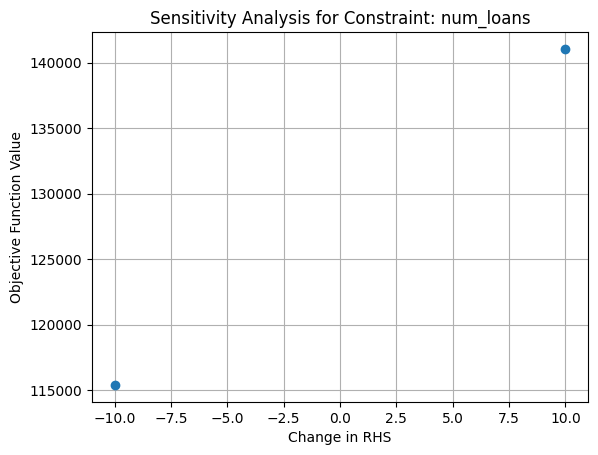

In [26]:
# sensitivity
constraint_name = "num_loans" # Replace with the name of the constraint
original_rhs = modelA.getConstrByName(constraint_name).RHS  # Get the original RHS value
rhs_changes = np.linspace(-10, 10, 50)  # Define a range of RHS changes

objective_values = []
for change in rhs_changes:
    # Update the RHS value
    modelA.getConstrByName(constraint_name).RHS = original_rhs + change

    # Re-optimize the model
    modelA.optimize()

    # Store the objective function value
    if modelA.status == GRB.OPTIMAL:
        objective_values.append(modelA.ObjVal)
    else:
        objective_values.append(np.nan)  # Store NaN if not optimal

# Restore the original RHS value
modelA.getConstrByName(constraint_name).RHS = original_rhs

# Analyze the results (e.g., plot objective values vs. RHS changes)
import matplotlib.pyplot as plt
plt.plot(rhs_changes, objective_values, marker='o')
plt.xlabel("Change in RHS")
plt.ylabel("Objective Function Value")
plt.title(f"Sensitivity Analysis for Constraint: {constraint_name}")
plt.grid(True)
plt.show()

## Maximize Total Revenue w/ Budget

In [27]:
modelB = gp.Model(env=env)

selection = modelB.addVars(indices, vtype=GRB.BINARY, name='selection')
invest = modelB.addVars(indices, lb=0, name="inv_amnt")

modelB.setObjective(sum(selection[i] * r[i] * invest[i] for i in indices), GRB.MAXIMIZE)

# modelB.addConstr(sum(selection[i] for i in indices) <= 100, name="num_loans_upper")
# modelB.addConstr(sum(selection[i] for i in indices) >= 90, name="num_loans_lower")
modelB.addConstrs((invest[i] <= a.loc[i] for i in indices), name="inv_max")
modelB.addConstrs((invest[i] <= selection[i] * a.loc[i] for i in indices), name="inv_selection")
modelB.addConstrs((invest[i] >= 25 * selection[i] for i in indices), name="inv_min")
modelB.addConstr(sum(invest[i] for i in indices) <= 10000, name="budget")

<gurobi.Constr *Awaiting Model Update*>

In [28]:
modelB.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2608044 - for non-commercial use only - registered to tc___@andrew.cmu.edu
Optimize a model with 389011 rows, 259340 columns and 778020 nonzeros
Model fingerprint: 0xa2a18287
Model has 129670 quadratic objective terms
Variable types: 129670 continuous, 129670 integer (129670 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-02, 8e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 4e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 129670 rows and 0 columns
Presolve time: 0.48s
Presolved: 389011 rows, 389010 columns, 1037360 nonzeros
Variable types: 259340 continuous, 129670 integer (129670 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showi

In [29]:
print("Objective = ", modelB.ObjVal)
modelB.printAttr('X')

Objective =  395.26769079540406

    Variable            X 
-------------------------
selection[563331]            1 
inv_amnt[563331]        10000 


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2608044 - for non-commercial use only - registered to tc___@andrew.cmu.edu
Optimize a model with 389011 rows, 259340 columns and 778020 nonzeros
Model fingerprint: 0x363a916d
Model has 129670 quadratic objective terms
Variable types: 129670 continuous, 129670 integer (129670 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-02, 8e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 4e+04]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint budget by 10000.000000000

Found heuristic solution: objective -0.0000000
Presolve removed 389011 rows and 259340 columns
Presolve time: 0.04s
Presolve: All rows and columns removed

Explored 0 node

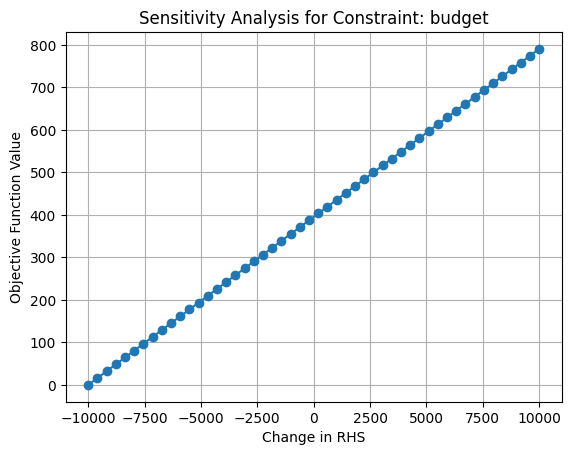

In [36]:
# sensitivity
constraint_name = "budget" # Replace with the name of the constraint
original_rhs = modelB.getConstrByName(constraint_name).RHS  # Get the original RHS value
rhs_changes = np.linspace(-10000, 10000, 50)  # Define a range of RHS changes

objective_values = []
for change in rhs_changes:
    # Update the RHS value
    modelB.getConstrByName(constraint_name).RHS = original_rhs + change

    # Re-optimize the model
    modelB.optimize()

    # Store the objective function value
    if modelB.status == GRB.OPTIMAL:
        objective_values.append(modelB.ObjVal)
    else:
        objective_values.append(np.nan)  # Store NaN if not optimal

# Restore the original RHS value
modelB.getConstrByName(constraint_name).RHS = original_rhs

# Analyze the results (e.g., plot objective values vs. RHS changes)
import matplotlib.pyplot as plt
plt.plot(rhs_changes, objective_values, marker='o')
plt.xlabel("Change in RHS")
plt.ylabel("Objective Function Value")
plt.title(f"Sensitivity Analysis for Constraint: {constraint_name}")
plt.grid(True)
plt.show()

### Minimize Risk

In [37]:
modelR = gp.Model(env=env)

selection = modelR.addVars(indices, vtype=GRB.BINARY, name='selection')
invest = modelR.addVars(indices, lb=0, name="inv_amnt")

modelR.setObjective(sum(selection[i] * r[i] for i in indices), GRB.MINIMIZE)

# modelR.addConstr(sum(selection[i] for i in indices) <= 100, name="num_loans_upper")
modelR.addConstr(sum(selection[i] for i in indices) >= 90, name="num_loans_lower")
modelR.addConstrs((invest[i] <= a.loc[i] for i in indices), name="inv_max")
modelR.addConstrs((invest[i] <= selection[i] * a.loc[i] for i in indices), name="inv_selection")
modelR.addConstrs((invest[i] >= 25 * selection[i] for i in indices), name="inv_min")
modelR.addConstr(sum(invest[i] for i in indices) <= 10000, name="budget")

<gurobi.Constr *Awaiting Model Update*>

In [38]:
modelR.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2608044 - for non-commercial use only - registered to tc___@andrew.cmu.edu
Optimize a model with 389012 rows, 259340 columns and 907690 nonzeros
Model fingerprint: 0x7b8cb362
Variable types: 129670 continuous, 129670 integer (129670 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [1e-02, 4e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+01, 4e+04]
Presolve removed 389010 rows and 129670 columns
Presolve time: 0.17s
Presolved: 2 rows, 129670 columns, 259340 nonzeros
Variable types: 0 continuous, 129670 integer (129670 binary)
Found heuristic solution: objective 0.9481942
Performing another presolve...
Presolve removed 1 rows and 129669 columns
Presolve time: 0.06s

Explored 1 nodes (0 simplex iterations) in 0.39 seconds (0.93 work units)


In [39]:
print("Objective = ", modelR.ObjVal)
modelR.printAttr('X')

Objective =  0.948194217798609

    Variable            X 
-------------------------
selection[500840]            1 
selection[86479]            1 
selection[543415]            1 
selection[646559]            1 
selection[387942]            1 
selection[420058]            1 
selection[546455]            1 
selection[342920]            1 
selection[422041]            1 
selection[219863]            1 
selection[469750]            1 
selection[329646]            1 
selection[365954]            1 
selection[548753]            1 
selection[616478]            1 
selection[91638]            1 
selection[130970]            1 
selection[87157]            1 
selection[565845]            1 
selection[58027]            1 
selection[229421]            1 
selection[307232]            1 
selection[49199]            1 
selection[565548]            1 
selection[470745]            1 
selection[23060]            1 
selection[362488]            1 
selection[580082]            1 
selection[113086]        

### Returns

In [40]:
# maximum return
import re  # Import the regular expression module

# Assuming your output is stored in a string called 'output_string'
output_string = '''selection[226102]            1
selection[222245]            1
selection[208159]            1
selection[176412]            1 '''

# Extract indices using regular expressions
indices_string = re.findall(r'selection\[(\d+)\]', output_string)

# Convert to list of integers
selected_indices = [int(index) for index in indices_string]

print(selected_indices)
print(len(selected_indices))

[226102, 222245, 208159, 176412]
4


In [41]:
final_clean_data.loc[selected_indices]['ret_INTb'].mean()

np.float64(0.0039146638442535305)

In [42]:
# minimal risk
import re  # Import the regular expression module

# Assuming your output is stored in a string called 'output_string'
output_string = '''selection[500840]            1
selection[86479]            1
selection[543415]            1
selection[646559]            1
selection[387942]            1
selection[420058]            1
selection[546455]            1
selection[342920]            1
selection[422041]            1
selection[219863]            1
selection[469750]            1
selection[329646]            1
selection[365954]            1
selection[548753]            1
selection[616478]            1
selection[91638]            1
selection[130970]            1
selection[87157]            1
selection[565845]            1
selection[58027]            1
selection[229421]            1
selection[307232]            1
selection[49199]            1
selection[565548]            1
selection[470745]            1
selection[23060]            1
selection[362488]            1
selection[580082]            1
selection[113086]            1
selection[353454]            1
selection[156034]            1
selection[358563]            1
selection[616544]            1
selection[234025]            1
selection[138977]            1
selection[170455]            1
selection[641327]            1
selection[311307]            1
selection[183929]            1
selection[595619]            1
selection[419491]            1
selection[496741]            1
selection[242302]            1
selection[309872]            1
selection[73297]            1
selection[368067]            1
selection[416410]            1
selection[280215]            1
selection[243019]            1
selection[366160]            1
selection[586329]            1
selection[421245]            1
selection[623905]            1
selection[75580]            1
selection[219720]            1
selection[382239]            1
selection[417300]            1
selection[297285]            1
selection[343334]            1
selection[585203]            1
selection[299121]            1
selection[643433]            1
selection[371937]            1
selection[53265]            1
selection[66882]            1
selection[313780]            1
selection[51499]            1
selection[415084]            1
selection[36109]            1
selection[615536]            1
selection[108692]            1
selection[634285]            1
selection[60127]            1
selection[321077]            1
selection[362597]            1
selection[568943]            1
selection[198426]            1
selection[264597]            1
selection[506176]            1
selection[196801]            1
selection[325988]            1
selection[192194]            1
selection[145413]            1
selection[608393]            1
selection[333090]            1
selection[347718]            1
selection[449313]            1
selection[148063]            1
selection[110440]            1
selection[157954]            1'''

# Extract indices using regular expressions
indices_string = re.findall(r'selection\[(\d+)\]', output_string)

# Convert to list of integers
selected_indices = [int(index) for index in indices_string]

print(selected_indices)
print(len(selected_indices))

[500840, 86479, 543415, 646559, 387942, 420058, 546455, 342920, 422041, 219863, 469750, 329646, 365954, 548753, 616478, 91638, 130970, 87157, 565845, 58027, 229421, 307232, 49199, 565548, 470745, 23060, 362488, 580082, 113086, 353454, 156034, 358563, 616544, 234025, 138977, 170455, 641327, 311307, 183929, 595619, 419491, 496741, 242302, 309872, 73297, 368067, 416410, 280215, 243019, 366160, 586329, 421245, 623905, 75580, 219720, 382239, 417300, 297285, 343334, 585203, 299121, 643433, 371937, 53265, 66882, 313780, 51499, 415084, 36109, 615536, 108692, 634285, 60127, 321077, 362597, 568943, 198426, 264597, 506176, 196801, 325988, 192194, 145413, 608393, 333090, 347718, 449313, 148063, 110440, 157954]
90


In [44]:
final_clean_data.loc[selected_indices]['ret_INTb'].mean()

np.float64(0.057136079289583)

# Findings Update 3 Question

In [45]:
import pandas as pd
import numpy as np

lc_data = pd.read_parquet("/Users/goyolozano/Desktop/Mini 4/Value/Update 3/Deliverables/final_clean_data.parquet")

display(lc_data.head(5))
print(lc_data.columns)

,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,num_tl_90g_dpd_24m,pub_rec_bankruptcies,total_bc_limit,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc
0,15000.0,15000.0,60 months,12.39,336.64,C,10+ years,RENT,78000.0,Source Verified,...,0.0,0.0,10000.0,18.0,60,0.031898,0.106328,0.043907,0.063084,0.098421
1,10400.0,10400.0,36 months,6.99,321.08,A,8 years,MORTGAGE,58000.0,Not Verified,...,0.0,0.0,13000.0,20.0,36,-0.121420,-0.121420,-0.066501,-0.056377,-0.037779
2,7650.0,7650.0,36 months,13.66,260.20,C,< 1 year,RENT,50000.0,Source Verified,...,0.0,0.0,4900.0,8.0,36,-0.233901,-0.233901,-0.137057,-0.131796,-0.122050
3,12800.0,12800.0,60 months,17.14,319.08,D,10+ years,MORTGAGE,125000.0,Verified,...,0.0,0.0,4400.0,57.0,60,0.099459,0.104693,0.108924,0.123831,0.150708
4,21425.0,21425.0,60 months,15.59,516.36,D,6 years,RENT,63800.0,Source Verified,...,0.0,0.0,15000.0,17.0,60,0.038154,0.134660,0.050611,0.070516,0.107225


Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_pymnt', 'recoveries',
       'mths_since_last_delinq', 'acc_now_delinq', 'bc_util', 'mort_acc',
       'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies', 'total_bc_limit',
       'loan_length', 'term_num', 'ret_PESS', 'ret_OPT', 'ret_INTa',
       'ret_INTb', 'ret_INTc'],
      dtype='object')


In [46]:
# Cleaning Return Columns
cols_to_exclude = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTc"]
lc_data = lc_data.drop(columns=cols_to_exclude)

# Deafault Column
default_statuses = ["Charged Off", "Default"]
lc_data["default_label"] = lc_data["loan_status"].isin(default_statuses).astype(int)
print(lc_data.columns)

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_pymnt', 'recoveries',
       'mths_since_last_delinq', 'acc_now_delinq', 'bc_util', 'mort_acc',
       'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies', 'total_bc_limit',
       'loan_length', 'term_num', 'ret_INTb', 'default_label'],
      dtype='object')


# Deafult by Loan Grade

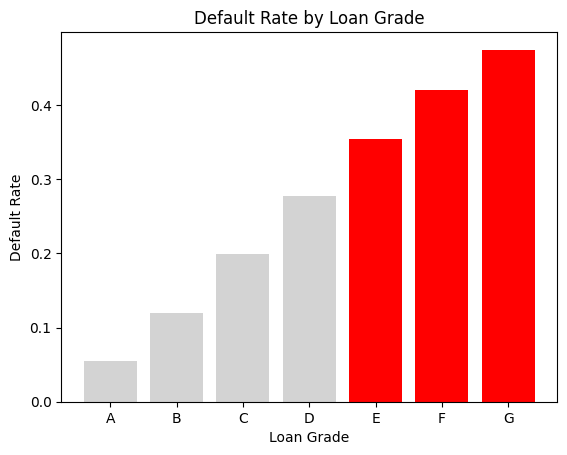

In [47]:
import matplotlib.pyplot as plt

# 1. Compute default rate by grade
default_by_grade = (
    lc_data
    .groupby('grade')['default_label']
    .mean()
    .reset_index(name='default_rate')
)

grades = default_by_grade['grade']
rates  = default_by_grade['default_rate']

# 2. Define grade buckets
safe   = {'A', 'B', 'C'}    # green
medium = {'D'}         # orange
# the rest (F, G) will be red

# 3. Map each grade to a color
colors = [
    'lightgrey'  if g in safe
    else 'lightgrey' if g in medium
    else 'red'
    for g in grades
]

# 4. Plot
plt.figure()
plt.bar(grades, rates, color=colors)
plt.xlabel('Loan Grade')
plt.ylabel('Default Rate')
plt.title('Default Rate by Loan Grade')
plt.xticks(rotation=0)
plt.show()



# Returns by loan grade

/var/folders/kr/_0jlkcjd3bz5k__n_t79wdnc0000gn/T/ipykernel_68326/2225996352.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


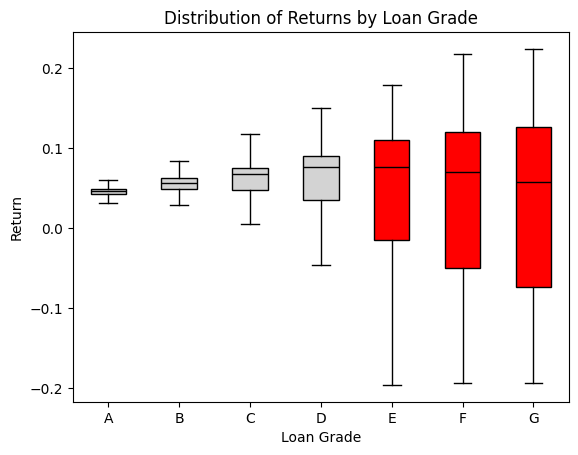

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Prepare grade list and corresponding return‑series
grades   = sorted(lc_data['grade'].unique())
ret_data = [lc_data.loc[lc_data['grade'] == g, 'ret_INTb'] for g in grades]

# 2. Define colors: lightgrey for A–D (first 4), red for F–G (last 2)
#    (E will also get lightgrey since it’s the 5th of 7)
colors = ['lightgrey']*4 + ['lightgrey']*(len(grades)-7) + ['red']*3

# 3. Draw boxplots without outliers, with patch_artist=True to fill boxes
fig, ax = plt.subplots()
bp = ax.boxplot(
    ret_data,
    labels=grades,
    showfliers=False,
    patch_artist=True
)

# 4. Apply our color scheme
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

# 5. Tweak medians to be visible
for median in bp['medians']:
    median.set_color('black')

ax.set_xlabel('Loan Grade')
ax.set_ylabel('Return')
ax.set_title('Distribution of Returns by Loan Grade')
plt.show()


# Decision Tree

In [49]:
lc_data.dtypes

loan_amnt                 float64
funded_amnt               float64
term                       object
int_rate                  float64
installment               float64
grade                      object
emp_length                 object
home_ownership             object
annual_inc                float64
verification_status        object
loan_status                object
purpose                    object
dti                       float64
delinq_2yrs               float64
open_acc                  float64
pub_rec                   float64
revol_bal                 float64
revol_util                float64
total_pymnt               float64
recoveries                float64
mths_since_last_delinq    float64
acc_now_delinq            float64
bc_util                   float64
mort_acc                  float64
num_tl_90g_dpd_24m        float64
pub_rec_bankruptcies      float64
total_bc_limit            float64
loan_length               float64
term_num                    int64
ret_INTb      

Tuning Decision Tree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'clf__max_depth': 5, 'clf__min_samples_leaf': 100}
Best CV ROC AUC: 0.6724

=== Test Metrics ===
Accuracy : 0.6082671396622195
ROC AUC  : 0.6718470137559045
Classification Report:
               precision    recall  f1-score   support

           0     0.8856    0.5961    0.7126    105622
           1     0.2717    0.6618    0.3852     24048

    accuracy                         0.6083    129670
   macro avg     0.5786    0.6289    0.5489    129670
weighted avg     0.7717    0.6083    0.6518    129670



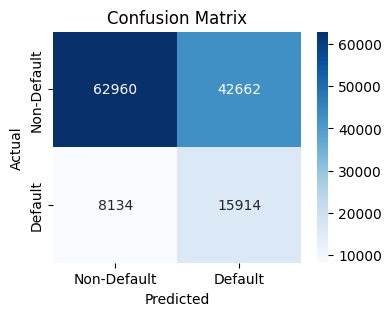

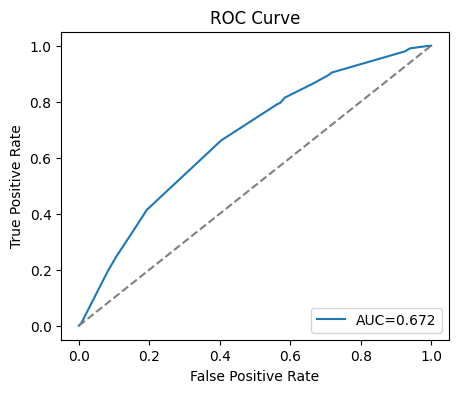

In [50]:
# ## Decision Tree with SMOTE (Speed‑Optimized)

# %%
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)

# 1. Define target and features, drop leakage columns
leakage_cols = ['loan_status','total_pymnt','recoveries','loan_length','ret_INTb']
y = lc_data['default_label']
X = lc_data.drop(columns=leakage_cols + ['default_label'])

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Identify feature types
cat_cols = ['grade','term','emp_length','home_ownership','verification_status','purpose']
num_cols = [c for c in X_train.columns if c not in cat_cols]

# 4. Preprocessing pipelines
num_transformer = ImbPipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler',   StandardScaler())
])
cat_transformer = ImbPipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',   OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
], remainder='drop')

# 5. Build Decision Tree pipeline with SMOTE
pipeline_dt = ImbPipeline([
    ('prep',  preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf',   DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

# 6. Speed‑optimized hyperparameter grid
param_grid_dt = {
    'clf__max_depth':       [3, 5, 10,15],
    'clf__min_samples_leaf':[50, 100, 150]
}

search_dt = GridSearchCV(
    pipeline_dt,
    param_grid_dt,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Tuning Decision Tree...")
search_dt.fit(X_train, y_train)
best_dt = search_dt.best_estimator_
print("Best parameters:", search_dt.best_params_)
print(f"Best CV ROC AUC: {search_dt.best_score_:.4f}")

# 7. Evaluate on test set
y_pred  = best_dt.predict(X_test)
y_proba = best_dt.predict_proba(X_test)[:, 1]

print("\n=== Test Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("ROC AUC  :", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non‑Default','Default'],
            yticklabels=['Non‑Default','Default'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


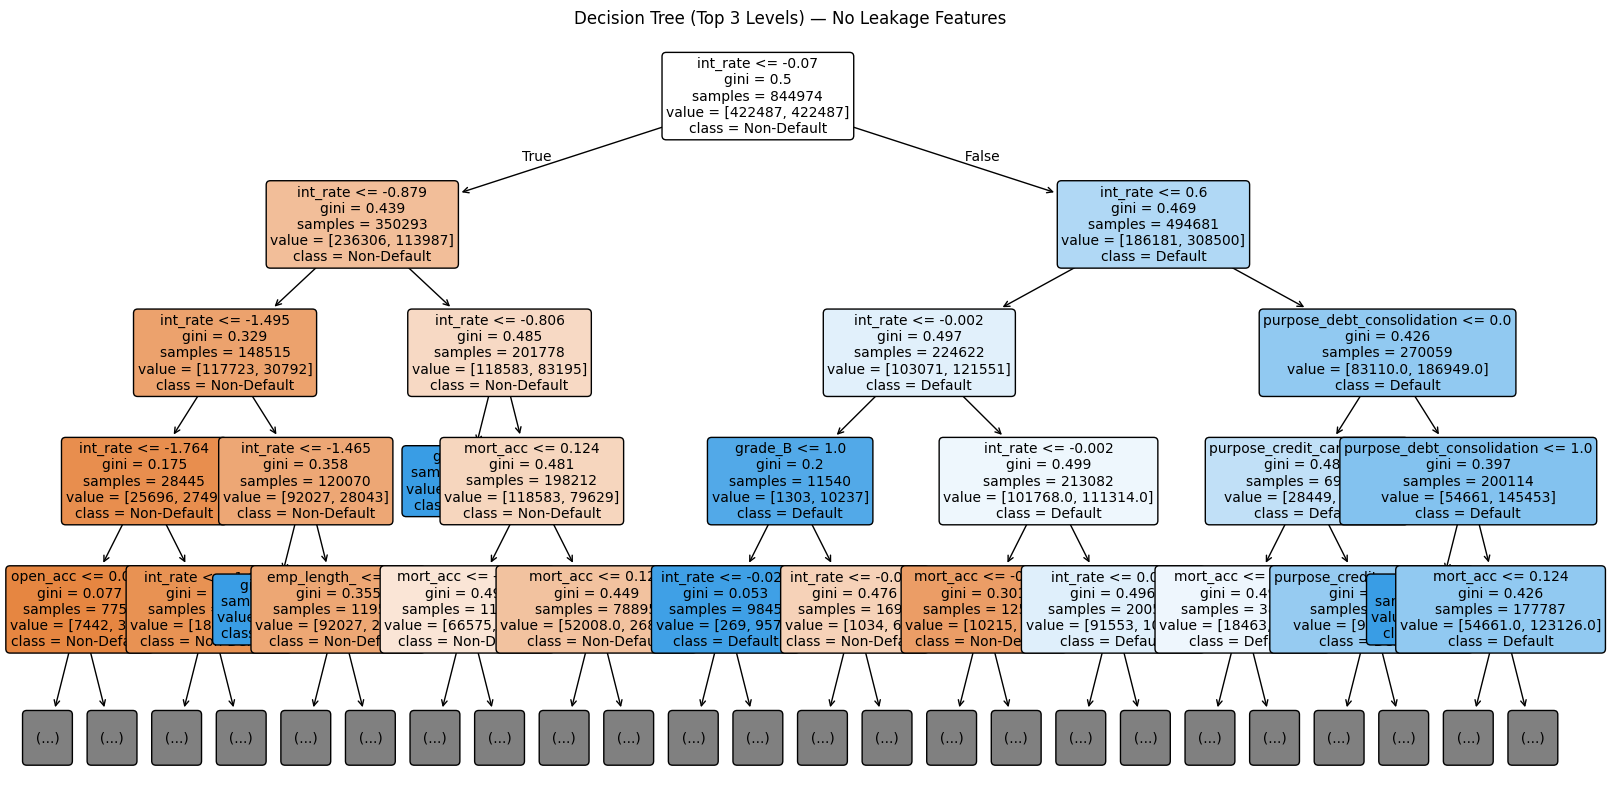

In [51]:
# ## Visualize Top 3 Levels of the Tuned Decision Tree (No Leakage)

# %%
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# 1. Extract the trained DecisionTreeClassifier and the ColumnTransformer
clf    = best_dt.named_steps['clf']
preproc = best_dt.named_steps['prep']

# 2. Re‑declare the feature lists (must match what you used above)
cat_cols = ['grade','term','emp_length','home_ownership','verification_status','purpose']
num_cols = [c for c in X_train.columns if c not in cat_cols]

# 3. Build the full list of feature names after one‑hot encoding
ohe = preproc.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = list(num_cols) + list(cat_feature_names)

# 4. Plot the tree (limit to top 3 levels for readability)
plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    max_depth=4,
    feature_names=feature_names,
    class_names=['Non-Default', 'Default'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree (Top 3 Levels) — No Leakage Features")
plt.show()

In [52]:
# ## Return‐Prediction Model (LassoCV)

from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1. Use the exact same X_train/X_test you already defined for the tree
#    so that the splits line up.
X_ret_train, X_ret_test = X_train.copy(), X_test.copy()
y_ret_train = lc_data.loc[X_ret_train.index, 'ret_INTb']
y_ret_test  = lc_data.loc[X_ret_test .index, 'ret_INTb']

# 2. Build preprocessing for returns (exclude default_label/leakage)
ret_num_cols = num_cols
ret_cat_cols = cat_cols

num_pipe_ret = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler',   StandardScaler())
])
cat_pipe_ret = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',   OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preproc_ret = ColumnTransformer([
    ('num', num_pipe_ret, ret_num_cols),
    ('cat', cat_pipe_ret, ret_cat_cols)
], remainder='drop')

# 3. LassoCV pipeline
pipeline_ret = Pipeline([
    ('prep',      preproc_ret),
    ('lasso',     LassoCV(cv=5, random_state=42, n_jobs=-1))
])

# 4. Fit
print("Training return model (LassoCV on ret_INTb)...")
pipeline_ret.fit(X_ret_train, y_ret_train)
print("Done. R² on hold‑out:", pipeline_ret.score(X_ret_test, y_ret_test))


Training return model (LassoCV on ret_INTb)...
Done. R² on hold‑out: 0.015032269859592828


In [53]:
# ## Compare 6 Pick‑100 Strategies on the Same Test Set

# %%
import numpy as np
import pandas as pd

N_LOANS_TO_PICK = 100
idx = X_test.index

# 1) Build DataFrames of tree‐predicted default probs & actual returns
proba_df = pd.DataFrame({'pr_default': y_proba}, index=idx)
y_test_returns = lc_data.loc[idx, 'ret_INTb']

# 2) Predict returns on X_test
pred_ret = pipeline_ret.predict(X_test)
pred_ret_series = pd.Series(pred_ret, index=idx)

# Strategy 1: Random
rng = np.random.RandomState(42)
pick1 = rng.choice(idx, size=min(N_LOANS_TO_PICK, len(idx)), replace=False)
print("Strat 1 Random    avg ret:", y_test_returns.loc[pick1].mean())

# Strategy 2: Lowest Pr(Default)
pick2 = proba_df['pr_default'].sort_values().head(N_LOANS_TO_PICK).index
print("Strat 2 Low PrD   avg ret:", y_test_returns.loc[pick2].mean())

# Strategy 3: Highest Predicted Return
pick3 = pred_ret_series.sort_values(ascending=False).head(N_LOANS_TO_PICK).index
print("Strat 3 High Ret  avg ret:", y_test_returns.loc[pick3].mean())

# Strategy 4: Highest Combined ER = (1−PrD)×PredRet
er = (1 - proba_df['pr_default']) * pred_ret_series
pick4 = er.sort_values(ascending=False).head(N_LOANS_TO_PICK).index
print("Strat 4 Comb ER   avg ret:", y_test_returns.loc[pick4].mean())

# Strategy 5: “Edge” Grades C & D
mask_cd = X_test['grade'].isin(['C','D'])
pick5 = proba_df.loc[mask_cd, 'pr_default'].sort_values().head(N_LOANS_TO_PICK).index
print("Strat 5 Edge C/D  avg ret:", y_test_returns.loc[pick5].mean())

# Strategy 6: Tiered Grade (Risky→Safe)
risky = proba_df.loc[X_test['grade'].isin(list('CDEFG')), 'pr_default'].sort_values()
safe  = proba_df.loc[X_test['grade'].isin(['A','B']), 'pr_default'].sort_values()
pick6 = list(risky.head(N_LOANS_TO_PICK).index)
if len(pick6) < N_LOANS_TO_PICK:
    pick6 += list(safe.head(N_LOANS_TO_PICK - len(pick6)).index)
print("Strat 6 Tiered    avg ret:", y_test_returns.loc[pick6].mean())

Strat 1 Random    avg ret: 0.04066447432582983
Strat 2 Low PrD   avg ret: 0.038871904153984616
Strat 3 High Ret  avg ret: 0.05315078740074155
Strat 4 Comb ER   avg ret: 0.05415116499445733
Strat 5 Edge C/D  avg ret: 0.047417057838564015
Strat 6 Tiered    avg ret: 0.069166532151941


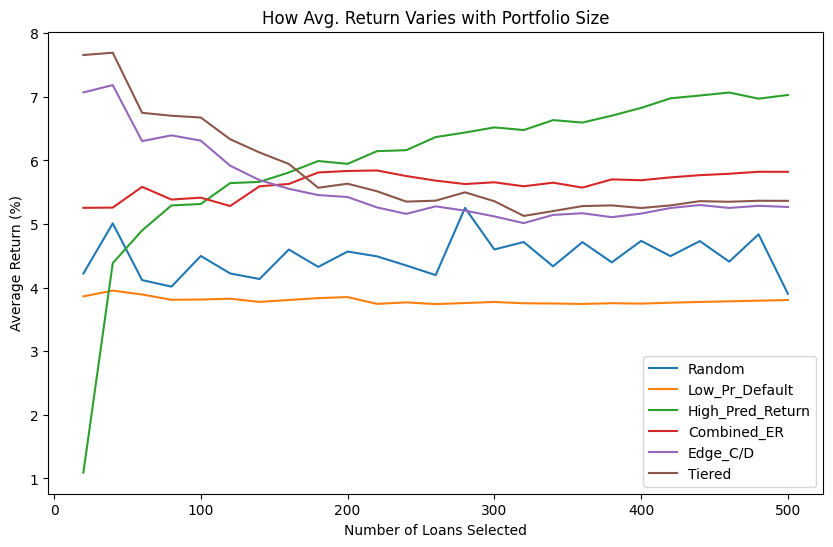

In [54]:
# ## How Avg Return Changes as You Pick More Loans

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Set up
ks = list(range(20, 501, 20))    # pick sizes from 20 to 1000
idx = X_test.index
rng = np.random.RandomState(42)

# pre‑existing structures:
# proba_df['pr_default'], pred_ret_series, y_test_returns

# 2) Containers for each strategy
results = {
    'Random'           : [],
    'Low_Pr_Default'   : [],
    'High_Pred_Return' : [],
    'Combined_ER'      : [],
    'Edge_C/D'         : [],
    'Tiered'           : []
}

# 3) Loop over different portfolio sizes
for k in ks:
    # --- Strat 1: Random ---
    pick = rng.choice(idx, size=min(k, len(idx)), replace=False)
    results['Random'].append(y_test_returns.loc[pick].mean())

    # --- Strat 2: Lowest Pr(Default) ---
    pick = proba_df['pr_default'].nsmallest(k).index
    results['Low_Pr_Default'].append(y_test_returns.loc[pick].mean())

    # --- Strat 3: Highest Predicted Return ---
    pick = pred_ret_series.nlargest(k).index
    results['High_Pred_Return'].append(y_test_returns.loc[pick].mean())

    # --- Strat 4: Combined ER = (1−PrD)×PredRet ---
    er_scores = (1 - proba_df['pr_default']) * pred_ret_series
    pick = er_scores.nlargest(k).index
    results['Combined_ER'].append(y_test_returns.loc[pick].mean())

    # --- Strat 5: Edge C/D only ---
    mask_cd = X_test['grade'].isin(['C','D'])
    pick = proba_df.loc[mask_cd, 'pr_default'].nsmallest(k).index
    results['Edge_C/D'].append(y_test_returns.loc[pick].mean())

    # --- Strat 6: Tiered (Risky→Safe) ---
    risky = proba_df.loc[X_test['grade'].isin(list('CDEFG')), 'pr_default'].nsmallest(k)
    pick = list(risky.index)
    if len(pick) < k:
        needed = k - len(pick)
        safe = proba_df.loc[X_test['grade'].isin(['A','B']), 'pr_default'].nsmallest(needed)
        pick += list(safe.index)
    results['Tiered'].append(y_test_returns.loc[pick].mean())

# 4) Build DataFrame
df_ret = pd.DataFrame(results, index=ks) * 100  # convert to percentage

# 5) Plot
plt.figure(figsize=(10,6))
for strat in df_ret.columns:
    plt.plot(df_ret.index, df_ret[strat], label=strat)

plt.xlabel("Number of Loans Selected")
plt.ylabel("Average Return (%)")
plt.title("How Avg. Return Varies with Portfolio Size")
plt.legend(loc="lower right")
plt.grid(False)
plt.show()
